<header>
   <p  style='font-size:36px;font-family:Arial; color:#F0F0F0; background-color: #00233c; padding-left: 20pt; padding-top: 20pt;padding-bottom: 10pt; padding-right: 20pt;'>
       Financial Services Customer Journey
  <br>
       <img id="teradata-logo" src="https://storage.googleapis.com/clearscape_analytics_demo_data/DEMO_Logo/teradata.svg" alt="Teradata" style="width: 125px; height: auto; margin-top: 20pt;">
    </p>
</header>

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Introduction </b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>In this use case we will show several different analytic techniques to analyze various aspects of a customer journey using Vantage. Specifically, we will use the Attribution and nPath® functions.<p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Here is an overview of the scenario we will be covering: </p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We want to look at the important interactions' customers have with a retail bank. We would like to show how we can use Vantage to discover new insights across various steps in a customer journey.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Starting with <b>customer acquisition</b>, how do we:</p>
<ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li style = 'font-size:16px;font-family:Arial;color:#00233C'>Find new customers</li>
    <li style = 'font-size:16px;font-family:Arial;color:#00233C'>Measure marketing attribution</li>
<li style = 'font-size:16px;font-family:Arial;color:#00233C'>How can we increase ROI and maximize marketing effectiveness, minimize the time to conversion?</li>
</ol>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Next we will look at <b>customer adoption</b>:</p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
What leads customers to additional high end products such as wealth management accounts?
    </p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Customers interact with the bank in many ways both online and offline
There are many different data sources such as in-branch interactions with tellers, online banking, email, call center logs etc. It is necessary to look at <b>all</b> of them to see the full picture.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Vantage is very adept at aggregating data sources, it has built in connectivity to various cloud object stores as well as QueryGrid connectors directly to Hadoop, Oracle and more.
We will be using a dataset aggregated from all of these channels. Other demos cover the integration and aggregation steps, but this is out of scope in our case.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We will see later that the insights we find are coming from these various channels both online AND offline.</p>

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>1. Connect to Vantage</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>You will be prompted to provide the password. Enter your password, press the Enter key, then use down arrow to go to next cell. Begin running steps with Shift + Enter keys.</p>

In [1]:
%connect local, hidewarnings=true

Password: ········


Success: 'local' connection established and activated for user 'demo_user', with default database 'demo_user'


<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Setup for execution of notebook. Begin running steps with Shift + Enter keys.</p>


In [2]:
SET query_band='DEMO=FSCustomerJourney_SQL.ipynb;' UPDATE FOR SESSION;

Success: 1 rows affected

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>2. Getting Data for This Demo</b>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We have provided data for this demo on cloud storage.  You have the option of either running the demo using foreign tables to access the data without using any storage on your environment or downloading the data to local storage which may yield somewhat faster execution, but there could be considerations of available storage.  There are two statements in the following cell, and one is commented out.  You may switch which mode you choose by changing the comment string. 


In [3]:
call get_data('DEMO_Financial_cloud');    -- takes about 3 minutes
-- call get_data('DEMO_Financial_local');    -- takes about 7 minutes

Success: 0 rows affected

Success: 0 rows affected

,Message
1,That ran for 0:00:52.42 with 17 statements and 0 errors.


<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Optional step – if you want to see status of databases/tables created and space used.</p>


In [4]:
call space_report();  -- optional, takes about 10 seconds

Success: 0 rows affected

Success: 0 rows affected

,Space_Report
1,"You have: #databases=3 #tables=52 #views=10 You have used 14.7 MB of 27,890.4 MB available - 0.1% ... Space Usage OK"
2,
3,Database Name #tables #views Avail MB Used MB
4,"demo_user 51 2 27,880.3 MB 14.5 MB"
5,DEMO_Financial 0 7 0.0 MB 0.0 MB
6,DEMO_GraphAnalysis 0 1 0.0 MB 0.0 MB
7,DEMO_GraphAnalysis_db 1 0 10.1 MB 0.2 MB


<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>3. Customer Acquisition</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>This is the first part of our journey. We will focus on the opening of a credit card account. We want to figure out where our customers are coming from and how can we maximize our marketing return on investment (ROI)?
We will use the powerful marketing Attribution function in Vantage to look at the multi-channel data.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>This will allow us to quantify marketing effectiveness of both our promotions and channels (online and offline). Which promotions are most effective? Using this information we can then optimize marketing spend and placement.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We will create some tables that allow us to send large numbers of parameters programmatically to the Attribution analytic function.</p>

In [5]:
CREATE MULTISET TABLE FSCJ_conversion_events (
    conversion_event VARCHAR(55)
)
NO PRIMARY INDEX;

Success: 0 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We want to find when people have booked accounts both online and offline and use that as our success criteria: </p>

In [6]:
INSERT INTO FSCJ_conversion_events VALUES('ACCOUNT_BOOKED_ONLINE');
INSERT INTO FSCJ_conversion_events VALUES('ACCOUNT_BOOKED_OFFLINE');

Success: 1 rows affected

Success: 1 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Vantage allows us to specify what type of attribution models we would like to apply. In this case we will keep it simple and choose a basic 'UNIFORM' strategy.</p>

In [7]:
CREATE MULTISET TABLE FSCJ_attribution_model (
    id    INTEGER,
    model VARCHAR(100)
)
NO PRIMARY INDEX;

Success: 0 rows affected

In [8]:
INSERT INTO FSCJ_attribution_model VALUES(0, 'SIMPLE');
INSERT INTO FSCJ_attribution_model VALUES(1, 'UNIFORM:NA');

Success: 1 rows affected

Success: 1 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Now we are ready to invoke the Attribution function on our dataset. The dataset has all kinds of cross channel customer interactions we can analyze.</p>

In [9]:
CREATE MULTISET TABLE FSCJ_marketing_attribution AS (
    SELECT * FROM Attribution (
        ON (
            SELECT
                customer_identifier, interaction_timestamp, 
                TRANSLATE(interaction_type USING UNICODE_TO_LATIN) AS interaction_type, customer_days_active, 
                customer_type, marketing_placement, marketing_description, marketing_category,
                interaction_type || product_category AS interaction_product
            FROM DEMO_Financial.Customer_Journey
            WHERE
                interaction_type IN ('ACCOUNT_BOOKED_OFFLINE', 'ACCOUNT_BOOKED_ONLINE', 'CLICK', 'REFERRAL', 'BROWSE')
                AND product_category <> '-1'
        ) 
        PARTITION BY customer_identifier
        ORDER BY interaction_timestamp
        ON FSCJ_conversion_events AS ConversionEventTable DIMENSION
        ON FSCJ_attribution_model AS FirstModel DIMENSION
        USING
            EventColumn ('interaction_type')
            TimestampColumn ('interaction_timestamp')
            WindowSize('rows:10')
    ) AS attrib
)
WITH DATA;

Success: 0 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Marketing attribution aims to identify the events leading to the opening of a credit card account and assign value to them. The specific conversion events in the data are 'ACCOUNT_BOOKED_ONLINE', 'ACCOUNT_BOOKED_OFFLINE'. Thus calculating the most influential events and channels that are driving customer acquisition. The attribution function in Vantage supports a variety of standard attribution models. Using Vantage we can quickly see how changes to the attribution model/parameters will affect our analyses!</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Now let's get some summary statistics from the results:</p>

In [10]:
SELECT marketing_description, AVG(attribution) AS avg_attrib, SUM(attribution) AS sum_attrib, AVG(-time_to_conversion)/3600 AS time_to_conversion
FROM FSCJ_marketing_attribution 
WHERE marketing_description NOT IN ('\N', '-1')
GROUP BY marketing_description;

,MARKETING_DESCRIPTION,avg_attrib,sum_attrib,time_to_conversion
1,OTHER PROMOTION,0.12269708441256559,58.64920634920635,10.126256256256257
2,MONEYSUPERMARKET.COM PROMOTION,0.2220879120879121,14.435714285714287,7.953019323671498
3,REWARDS CARD PROMOTION,0.10231916295930137,29.570238095238096,39.61428451178451
4,GOLD CARD PROMOTION II,0.14665750915750916,7.626190476190477,2.279333333333333
5,PLATINUM CARD PROMOTION,0.07232704402515723,3.833333333333333,19.674027777777777
6,HOTEL CARD PROMOTION,0.09703703703703703,4.366666666666666,6.186361111111111
7,SECURED CARD PROMOTION,0.03439153439153439,2.1666666666666665,11.110805555555556
8,AIRLINE CARD PROMOTION,0.08527966742252456,23.281349206349205,9.534586288416076
9,GOLD CARD PROMOTION,0.11260683760683761,7.319444444444445,13.39695987654321


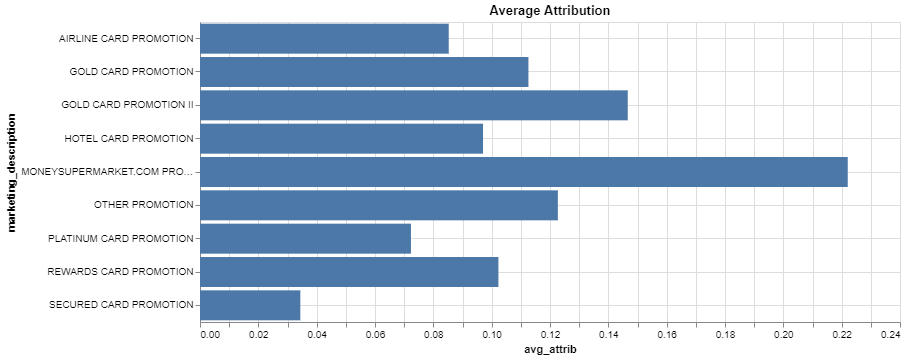

In [11]:
%chart x=avg_attrib, y=marketing_description, gridx=true, gridy=true, mark=bar, title="Average Attribution", width=700, height=300

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The above visualization is centered around the various promotions we have run. The larger the bar the more influence they had towards a customer opening an account. </p>



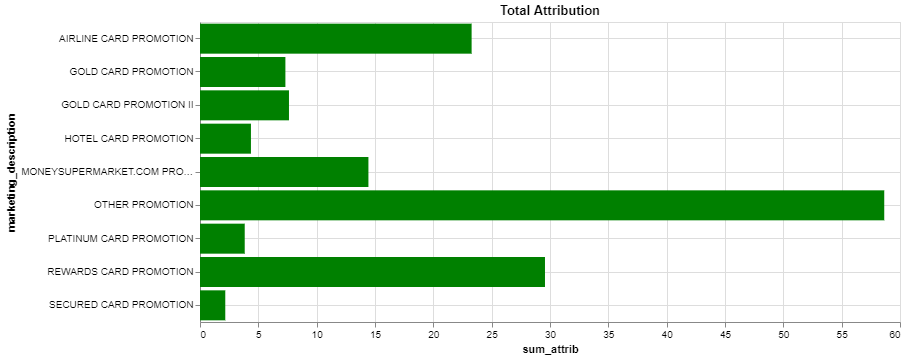

In [12]:
%chart x=sum_attrib, y=marketing_description, gridx=true, gridy=true, mark=bar, color=green, title="Total Attribution", width=700, height=300

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The chart above shows the total attribution score the promotion had. So, the biggest drivers of signups will be the longest. Here the OTHER PROMOTIONS followed by REWARDS CARD PROMOTION and then AIRLINE CARD PROMOTION. </p>



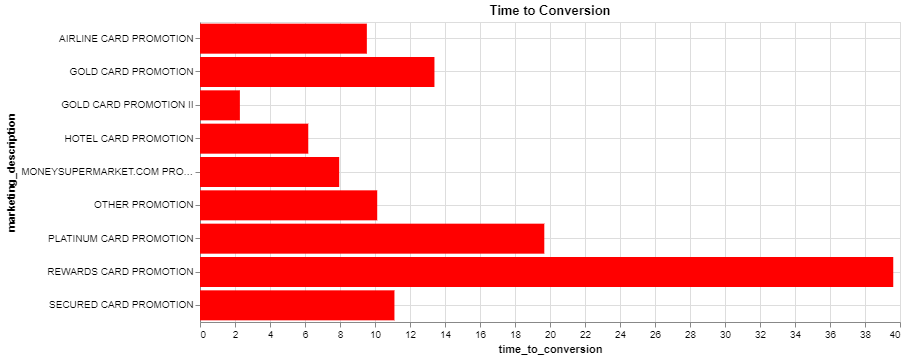

In [13]:
%chart x=time_to_conversion, y=marketing_description, gridx=true, gridy=true, mark=bar, color=red, title="Time to Conversion", width=700, height=300

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The above chart shows time to conversion, so how many hours on average that promotion took place before the user went ahead and signed up. The shorter time - the faster people took action. We can see that the Gold Card Promotion II did overall the best, followed by the Hotel card and MoneySupermarket.com promotions.  </p>

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>4. Channel analysis</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We have different promotions and advertising networks, now let's take a look at the traction we are getting with the various promotions across different channels:</p>

In [14]:
SELECT marketing_category, marketing_placement, SUM(attribution) AS total_attribution 
FROM FSCJ_marketing_attribution 
WHERE marketing_description NOT IN ('\N', '-1')
GROUP BY 1, 2;

,MARKETING_CATEGORY,MARKETING_PLACEMENT,total_attribution
1,EMAIL_ADVERTISING,EMAIL,22.43015873015873
2,INBRANCH,INBRANCH_REFERRAL,24.302777777777777
3,OFFSITE_DISPLAY_ADVERTISING,AFFILIATES,8.75
4,OFFSITE_DISPLAY_ADVERTISING,DOTOMI,0
5,SEARCH_ADVERTISING,GOOGLE,16.291666666666664
6,OFFSITE_DISPLAY_ADVERTISING,MINT.COM,4.309523809523808
7,OFFSITE_DISPLAY_ADVERTISING,FACEBOOK,4.17063492063492
8,ONSITE_DISPLAY_ADVERTISING,HOMEPAGE_BANNER,44.88333333333333
9,OFFSITE_DISPLAY_ADVERTISING,BLOOMBERG.COM,8.75
10,OFFSITE_DISPLAY_ADVERTISING,AOL,0


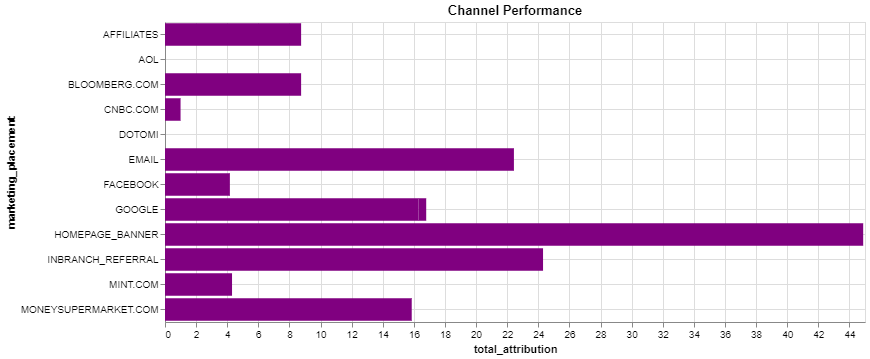

In [15]:
%chart x=total_attribution, y=marketing_placement, gridx=true, gridy=true, mark=bar, color=purple, title="Channel Performance", width=700, height=300

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The next visual is centered around the various channels where we ran our marketing. The length of the bar shows the overall total attribution to that channel. The colors correspond to the promotions that we looked at in the top view, so we can see which promotions were on which channels and the performance of each. In the data resultset you can see that there is email, in branch (offline) as well as web. </p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>For the digital channels - overall we can see that the homepage ads did the best followed by email and Google searches. </p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Using a BI tool we can take this analysis to another level. We do not have BI tool available in this environment so we have captured a screen image displaying an analysis of data produced by the analysis we did using the queries above. </p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The Top chart shows the Total Attributions for various kinds of promotions. The biggest drivers are the promotions that have the largest circle size. </p>
<img  src="images/ChannelPerformance.png"/>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The chart below with vertical lines shows the various channels and the colors of the bars indicate the type of promotion. Larger the size of the colored bar , more the contribution of that promotion using the specified channel. </p>

<img  src="images/AttrSumm.png"/>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Now we can see the promotions and their success across the various channels. We can see an interesting insight that the Money Supermarket promotion and the Gold Card Promotion II were our most effective promotions. It is interesting to compare Gold Card II to the first Gold Card Promotion. Looking down at our channels we can see that the first Gold Card promotion was only run over email and the Gold Card Promotion II was run on multiple channels and it was a lot more effective for the same exact product. </p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Using this dashboard and the power of Vantage can easily compare the different promotions and we can also see that we did a special promotion on MoneySupermarket.com that was particularly effective. This was only run on that particular channel and had both a quick time to conversion as well as strong average attribution.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We can also look at some other ones. We can see that we did a Rewards Card promotion that did well across channels but was particularly effective through in branch referrals. The airline card promotion did the best on the homepage and Google vs. the other channels.</p>

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>5. Path To Adoption</b>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We want to see how our customers are opening higher end accounts such as wealth management. Many retail banks have found wealth management to be a key profit centre so they are looking to build their business in this area.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We can use powerful nPath® analytic function in Vantage to do pattern/time series analysis that is very hard to do in SQL. We want to see the common paths that customers take when they go to open a wealth management account. We will also look at the affiliation between the other accounts that wealth management customers hold. </p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>In the code here you can see a few key points:</p>
<li style = 'font-size:16px;font-family:Arial;color:#00233C'>We are concatenating the interaction and the product category to make unique events </li>
<li style = 'font-size:16px;font-family:Arial;color:#00233C'>We are ignoring the starting / completing of the wealth management application because everyone does that by definition and in this case we want to reduce the noise. Further analysis could be done later on incomplete applications or other scenarios.</li>
<li style = 'font-size:16px;font-family:Arial;color:#00233C'>The __'PATTERN'__ we are searching for is 4 events followed by opening (ACCOUNT_BOOKED) a Wealth Management account.</li>
<li style = 'font-size:16px;font-family:Arial;color:#00233C'>The __'SYMBOLS'__ we are using is anything but opening a wealth management account is 'EVENT' and opening said account is 'ADOPTION' </li>

In [16]:
SELECT TOP 5 *
FROM nPath (
    ON (
        SELECT
            customer_identifier,
            interaction_timestamp,
            interaction_type,
            product_category,
            interaction_type || '_' || product_category AS event,
            marketing_category,
            marketing_description,
            marketing_placement,
            sales_channel,
            conversion_sales,
            conversion_cost,
            conversion_margin
        FROM
            DEMO_Financial.Customer_Journey
        WHERE
            product_category <> '-1'
            AND interaction_type || '_' || product_category <> 'STARTS_APPLICATION_WEALTH MANAGEMENT'
            AND interaction_type || '_' || product_category <> 'COMPLETE_APPLICATION_WEALTH MANAGEMENT'
    )
    PARTITION BY
        customer_identifier
    ORDER BY
        interaction_timestamp
    USING
        MODE (NONOVERLAPPING)
        -- Limit to a depth of 4
        PATTERN ('(EVENT){4}.ADOPTION')
        SYMBOLS (
            event NOT LIKE 'ACCOUNT_BOOKED%_WEALTH MANAGEMENT' AS EVENT,
            event LIKE 'ACCOUNT_BOOKED%' AND product_category = 'WEALTH MANAGEMENT' AS ADOPTION
        )
    RESULT (
        ACCUMULATE(event OF ANY(EVENT, ADOPTION)) AS interaction_type_list,
        COUNT(event OF ANY(EVENT, ADOPTION)) AS click_depth,
        FIRST(customer_identifier OF ADOPTION) AS customer_identifier,
        FIRST(product_category OF ADOPTION) AS product_category
    )
) a;

,interaction_type_list,click_depth,customer_identifier,product_category
1,"[ACCOUNT_BOOKED_ONLINE_CD, ACCOUNT_BOOKED_OFFLINE_CD, BROWSE_WEALTH MANAGEMENT, REFERRAL_WEALTH MANAGEMENT, ACCOUNT_BOOKED_OFFLINE_WEALTH MANAGEMENT]",5,103041743ispzuvy379652355,WEALTH MANAGEMENT
2,"[STARTS_APPLICATION_BROKERAGE, COMPARE_CHECKING, ACCOUNT_BOOKED_OFFLINE_BROKERAGE, OLB_CHECKING, ACCOUNT_BOOKED_OFFLINE_WEALTH MANAGEMENT]",5,108350971xmrixvo993049433,WEALTH MANAGEMENT
3,"[COMPLETE_APPLICATION_BROKERAGE, ACCOUNT_BOOKED_ONLINE_BROKERAGE, BROWSE_WEALTH MANAGEMENT, COMPARE_WEALTH MANAGEMENT, ACCOUNT_BOOKED_ONLINE_WEALTH MANAGEMENT]",5,113571841mglzzme226913342,WEALTH MANAGEMENT
4,"[COMPLETE_APPLICATION_SAVINGS, ACCOUNT_BOOKED_ONLINE_SAVINGS, COMPARE_WEALTH MANAGEMENT, ENROLL_AUTO_SAVINGS_CHECKING, ACCOUNT_BOOKED_ONLINE_WEALTH MANAGEMENT]",5,106966564pzjxhia819813298,WEALTH MANAGEMENT
5,"[COMPLETE_APPLICATION_BROKERAGE, COMPARE_BROKERAGE, ACCOUNT_BOOKED_ONLINE_BROKERAGE, BROWSE_WEALTH MANAGEMENT, ACCOUNT_BOOKED_ONLINE_WEALTH MANAGEMENT]",5,113852197uxhbxhc635320451,WEALTH MANAGEMENT


<p style = 'font-size:18px;font-family:Arial;'>A visualization of this gives us lots of insight into the most common paths that users are taking when opening Wealth Management accounts. This is an SQL notebook and we have another Notebook for same usecase which has python code for visualizations. A Sankey Diagram was created using the output (interacion_type_list) of the nPath® function used in the query above and below is the image for the nPath® function.</p>

<img  src="images/PathAnalysis.png"/>

<p style = 'font-size:16px;font-family:Arial;'>We can filter it down to the most popular paths:</p>

<img  src="images/PathForTopCust.png"/>

<p style = 'font-size:16px;font-family:Arial;'>The above diagram shows paths which have at least 16 customers on the path.  Of course, this notebook is just working with small data to demonstrate the functionality. In a real-world data volume, you’d be filtering for paths repeated hundreds or thousands of times. </p>
  
<p style = 'font-size:16px;font-family:Arial;'>So, let’s start by looking at the drivers of wealth management accounts online. We can see that the ‘Compare’ tool that the bank has on its’ website is a main step in opening an account. This allows you to compare its’ wealth management offerings to its competitors and this is proving to be very compelling. So, customers are browsing the offerings then using the compare tool and ultimately booking. </p>

<p style = 'font-size:16px;font-family:Arial;'>The other main drivers of online account signups are people signing up for an auto-savings plan. So, people that are savings minded tend to open wealth management accounts. Also, general browsing the offerings and opening a CD appear to be secondary paths as well. </p>

<p style = 'font-size:16px;font-family:Arial;'>Moving to offline - which we can see has different drivers. It appears to be predominately people that are opening other types of accounts as well such as CDs and Brokerage - both online and offline. We can see that the main path to booking a wealth management account offline is from in-branch referrals. So, people go into a branch and are opening another type of account and they are referred to opening a wealth management account as well!</p>

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>6. Cleanup </b></p>
<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Work Tables</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Cleanup work tables to prevent errors next time.</p>

In [17]:
DROP TABLE FSCJ_conversion_events;

Success: 14 rows affected

In [18]:
DROP TABLE FSCJ_attribution_model;

Success: 15 rows affected

In [19]:
DROP TABLE FSCJ_marketing_attribution;

Success: 24 rows affected

<p style = 'font-size:18px;font-family:Arial;color:#00233C'> <b>Databases and Tables </b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The following code will clean up tables and databases created above.</p>

In [20]:
call remove_data('DEMO_Financial');-- takes about 10 seconds, optional if you want to use the data later

Success: 0 rows affected

Success: 0 rows affected

,Message
1,Removed objects related to DEMO_Financial. That ran for 0:00:05.88


<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Dataset</b>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The data for this use case is stored in the `FSCustomerJourney` database. </p>

<b style = 'font-size:20px;font-family:Arial;color:#00233C'>Integrated Contact History </b>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The data for this use case is taken from Customer_Journey table(Details below) from the DEMO_FSCustomerJourney Database. It is data from various source systems and channels already combined and put into one big table. This is all of the customer interactions, in a customer system this might be a view on top of various source tables.</p>

`Customer_Journey`

- `customer_skey`: customer key
- `customer_identifier`: unique customer identifier
- `customer_cookie`: cookie placed on customers device
- `customer_online_id`: boolean - does the customer have an online account
- `customer_offline_id`: customer account number
- `customer_type`: is this a high value customer or just a vistor browsing the website?
- `customer_days_active`: how long has the customer been active
- `interaction_session_number`: session identifier
- `interaction_timestamp`: timestamp for this event
- `interaction_source`: channel this event is from (online / offline, in branch etc.)
- `interaction_type`: type of event
- `sales_channel`: channel a sales event was in
- `conversion_id`: sales conversion identifier
- `product_category`: what type of product the event concerned (checking, savings, cd etc..)
- `product_type`: unused
- `conversion_sales`: unused
- `conversion_cost`: unused
- `conversion_margin`: unused
- `conversion_units`: unused
- `marketing_code`: marketing identifier
- `marketing_category`: marketing channel (inbranch, website, email etc..)
- `marketing_description`: marketing campaign name
- `marketing_placement`: specific marketing outlet (Google, Bloomberg.com etc..)
- `mobile_flag`: boolean was on a mobile device
- `updt`: unused

<footer style="padding-bottom:35px; background:#f9f9f9; border-bottom:3px solid #00233C">
    <div style="float:left;margin-top:14px">ClearScape Analytics™</div>
    <div style="float:right;">
        <div style="float:left; margin-top:14px">
            Copyright © Teradata Corporation - 2023. All Rights Reserved
        </div>
    </div>
</footer>